In [47]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

import itertools as it
import math

# make the graph prettier (seaborn uses matplotlib but with better defaults)
sns.set_style("darkgrid")

In [65]:
def graph_instant(f, step_num):
    # f is a "math" function mapping from x to y
    x = np.arange(step_num)
    y = list(map(f, x))
    plt.step(x, y)
    
def graph_total(f, step_num):
    x = np.arange(step_num)
    values = list(map(f, x))
    # "integral" of instantaneous values
    y = np.cumsum(values)
    # remove initial value from array
    y = y - y[0]    
    plt.plot(x, y)
    
def adapter(opening_function, f, changeover):
    # returns a function which doesn't adapt until it has been called "enough" 
    opener = it.repeat(opening_function, changeover)
    funcs = it.chain(opener, it.repeat(f))
    def combined(*args, **kwargs):
        return next(funcs)(*args, **kwargs)
        
    return combined

def scenario(base, adapt_time):
    return lambda f: adapter(base, f, adapt_time)

In [66]:
def derived_cost(n):
    # n device inputs
    # device sample rates are tiered at powers of 2
    # adding more inputs decreases the samples per input
    factor = math.ceil(math.log(n, 2))
    return lambda _: (1/2**factor) * n

base = derived_cost(3)

# the generator for adapted functions for scenario 3
# note that this has to be called each time the function is used
# because calling it spends the adaptation time
scenario_3 = scenario(base, 3)

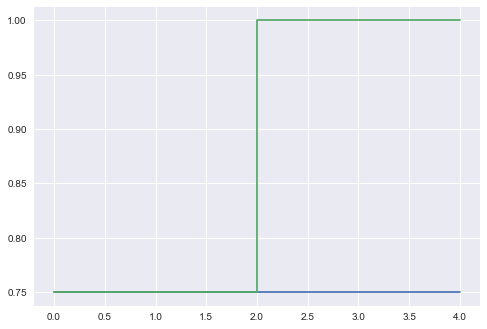

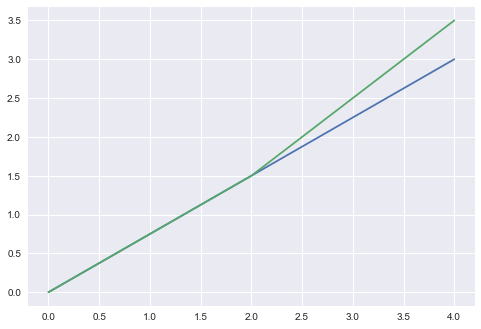

In [68]:
adapted = derived_cost(2)

graph_instant(base, 5)
graph_instant(scenario_3(adapted), 5)
plt.show()

graph_total(base, 5)
graph_total(scenario_3(adapted), 5)
plt.show()